## Development strategy with use spread between usually shares and pref shares 
##### 15.02.19

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas_datareader
from datetime import datetime,timedelta 
import statsmodels.tsa.stattools as st

In [2]:
dj=pd.read_csv('SBER.ME.csv') 
sp=pd.read_csv('SBERP.ME.csv')
dj['Date']=dj['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 
sp['Date']=sp['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 
port=pd.merge(dj[['Date','Adj Close']],sp[['Date','Adj Close']],on=['Date'])
port.columns=['Date','SBER','SBERP'];print(port.head(2))

        Date       SBER      SBERP
0 2016-02-16  86.277351  60.788368
1 2016-02-17  88.682137  62.246510


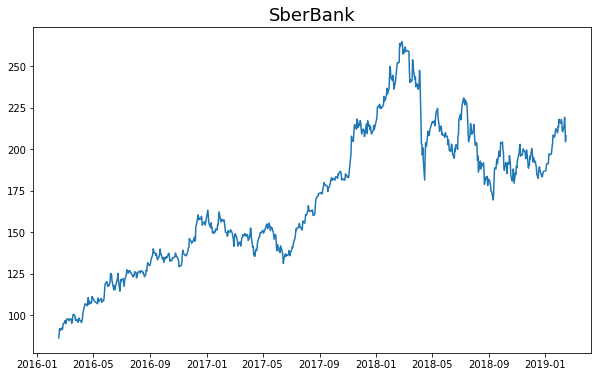

In [3]:
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,port.SBER)
_=plt.title('SberBank',fontsize=18)

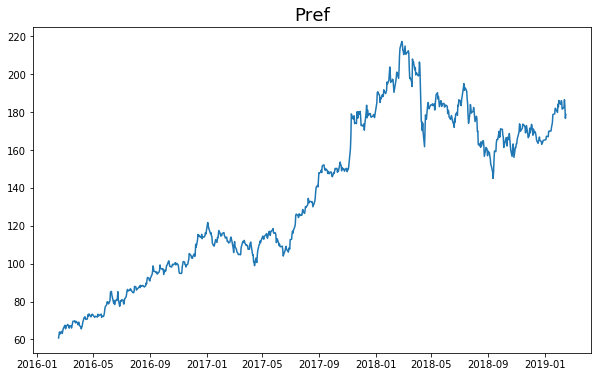

In [4]:
# Начертим график Dow
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,port.SBERP)
_=plt.title('Pref',fontsize=18)

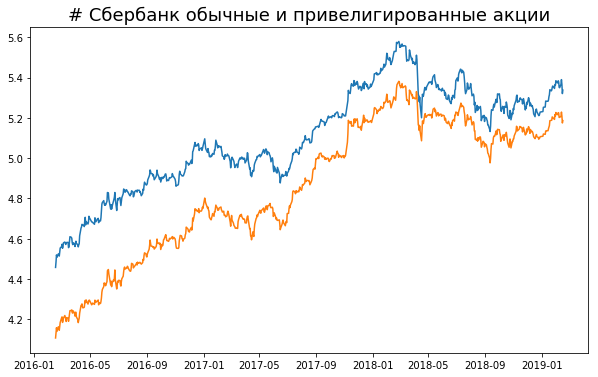

In [32]:
# Объединим оба графика
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,np.log(port.SBER))
_=plt.plot(port.Date,np.log(port.SBERP))
_=plt.title('# Сбербанк обычные и привелигированные акции',fontsize=18)

## Stationarity of the series

In [5]:
X=(np.array(np.log(port.SBER))).reshape(-1,1)
Y=(np.array(np.log(port.SBERP))).reshape(-1,1)
reg=lr(fit_intercept=False).fit(X,Y)
print(round(reg.coef_[0][0], 4))
print('The coefficient shows a high probability that the spread is stationary')

0.9534
The coefficient shows a high probability that the spread is stationary


In [7]:
Y_hat=reg.predict(X)
Y_resid=Y-Y_hat

In [8]:
print('The mean and standard deviation of the spread')
print(np.mean(Y_resid),np.std(Y_resid))

The mean and standard deviation of the spread
-0.004380778901278445 0.10110781677012097


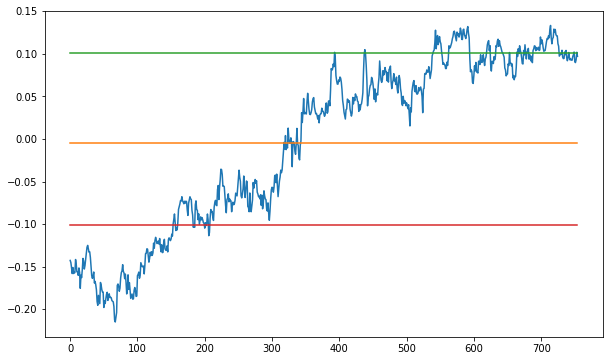

In [9]:
k=1
plt.figure(figsize=(10,6))
_=plt.plot(Y_resid)
_=plt.plot(np.repeat(np.mean(Y_resid),len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*k,len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*-k,len(Y_resid)))

## The graph shows that despite the stationarity, the spread value often goes beyond the 1st standard deviation

In [37]:
# calculation of regression equation residuals
def reg_resid_func(Instr_1,Instr_2):
    Y=np.log(Instr_1)
    X=np.log(Instr_2)
    reg=lr(fit_intercept=False)
    reg.fit(X,Y)
    Y_pred=reg.predict(X)
    return((Y-Y_pred),reg.coef_[0][0])

In [38]:
# checking for stationarity
def stationarity_check_func(data_spread,alpha=0.05):
    stationarity=False
    if st.adfuller(data_spread.ravel())[1]<alpha:
        stationarity=True
    return stationarity   

In [39]:
# the calculation of the distribution parameters of the spread
def param_func(data_spread):
    return (np.mean(data_spread),np.std(data_spread))

In [40]:
# receiving a signal
def signal_func_open(spread,mean,sigma,k):
    signal='No'
    if spread<=(mean-sigma*k):
        signal='Buy'
    elif spread>=mean+sigma*k:
        signal='Sell'
    return signal    

In [41]:
# converting price values to floating-point numbers
def get_prices(instr1,instr2):
    return (float(instr1),float(instr2))

In [42]:
class Position(object):
    
    def __init__(self):
        self._initial_position=(None,None,0,0,0)
        #date_initial,direction,price_1,price_2,beta,comission
        self._close_position=(None,None,0,0,0)
        #date_close,signal,price_1,price_2,comission

    @property
    def initial_position(self):
        return self._initial_position
    
    @initial_position.setter
    def initial_position(self, initial_position):
        self._initial_position=initial_position
        

    @property 
    def close_position(self):
        return self._close_position
        
    
    @close_position.setter 
    def close_position(self, close_position):
        self._close_position=close_position
        
        
    def get_result(self): 
        Date_setup,Direction,Instr_1_Price_initial,Instr_2_Price_initial,Beta,Comission_init=self._initial_position
        Date_close,Close_type,Instr_1_Price_close,Instr_2_Price_close,Comission_close=self._close_position
        if ((Date_setup==None)|(Date_close==None)):
            return 0
        else:
            return ((np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
                -(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_init) if Direction=='Long'\
    else (-(np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
          +(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_close)

In [43]:
pos=Position()
initial_position=('2019-04-02','Short',5,6,1.1,0)
pos.initial_position=initial_position
pos.close_position=('2019-04-02','Signal',5,8,0)
print(round(pos.get_result(), 4))

0.3165


## Implementation strategy

In [44]:
port_reduced=port
n=port_reduced.shape[0]
# convert the original price array to the format required for the regression equation
Instr_1=(np.array((port_reduced.iloc[0:,1]))).reshape(-1,1)
Instr_2=(np.array((port_reduced.iloc[0:,2]))).reshape(-1,1)
Date=list((port_reduced.iloc[0:,0]))
# strategy parametrs
days_stationarity_check_max=20 # initialization of strategy parameters
days_position_max=3 # number of days we hold a position
window=50 # the amount of data used to check stationarity
k=1.5# mu +/- k*sigma
comission=0 
stop_profit=0.0001
result=[] 
stationarity_check=False
pos_days=0
i=window
stationatity_check_index=window 

In [45]:
while ((i)<n):
    #print(i)
    if (pos_days==0):
        if (((i-stationatity_check_index)>days_stationarity_check_max)|(i==window)):
            resid,beta=reg_resid_func(Instr_1[(i-window):i],Instr_2[(i-window):i])
            stationarity=stationarity_check_func(resid) 
            if stationarity:
                mean,sigma=param_func(resid)
            stationatity_check_index=i
        if stationarity: 
            price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
            spread=float(np.log(price_1)-np.log(price_2)*beta)
            #print(np.log(price_1),np.log(price_2),spread,mean,sigma,(mean+sigma*k),beta)
            signal=signal_func_open(spread,mean,sigma,k)
            #print(signal)
            if (signal!='No'):
                pos_direction='Long' if signal=='Buy' else 'Short' 
                pos=Position() 
                pos.initial_position=(Date[i],pos_direction,price_1,price_2,beta,comission)
                pos_days=1
                i+=1
            else: i+=1   
        else: i+=1      
    else:
        price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
        if (pos_days<days_position_max):
            pos.close_position=(Date[i],'Signal',price_1,price_2,comission)
            res=pos.get_result()
            if (res>stop_profit):
                result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
                pos_days=0
            else:
                pos_days+=1
                i+=1
        else:
            pos.close_position=(Date[i],'Time',price_1,price_2,comission)
            result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
            pos_days=0
            #print('Time_close')n=port_reduced.shape[0]


In [46]:
df=pd.DataFrame(result,columns=['Date_open','Direction','Price_1_init','Price_2_init','Beta','Comission_init',\
                        'Date_close','Type','Price_1_close','Price_2_close','Comission_close','Result'])
# strategy result massive

In [47]:
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2016-12-28,Long,154.241302,114.951675,1.068586,0,2016-12-30,Signal,157.097626,115.619995,0,0.0122
1,2016-12-30,Long,157.097626,115.619995,1.068586,0,2017-01-05,Time,155.873489,118.934891,0,-0.0380
2,2017-01-05,Long,155.873489,118.934891,1.068586,0,2017-01-06,Signal,154.776291,118.070526,0,0.0007
3,2017-01-06,Long,154.776291,118.070526,1.068586,0,2017-01-09,Signal,152.654465,115.842773,0,0.0066
4,2017-01-09,Long,152.654465,115.842773,1.068586,0,2017-01-10,Signal,155.601456,116.368523,0,0.0143
5,2017-01-10,Long,155.601456,116.368523,1.068586,0,2017-01-12,Signal,152.581924,114.167503,0,0.0008
6,2017-01-12,Long,152.581924,114.167503,1.068586,0,2017-01-13,Signal,149.526108,110.727867,0,0.0125
7,2017-01-13,Long,149.526108,110.727867,1.068586,0,2017-01-16,Signal,149.308487,109.391228,0,0.0115
8,2017-01-19,Long,150.795578,111.378365,1.068586,0,2017-01-23,Signal,151.203629,111.191238,0,0.0045
9,2017-01-24,Long,154.377319,113.793243,1.068586,0,2017-01-25,Signal,154.386383,113.570473,0,0.0022


In [48]:
sum(df.Result*1000000) 

21900.0

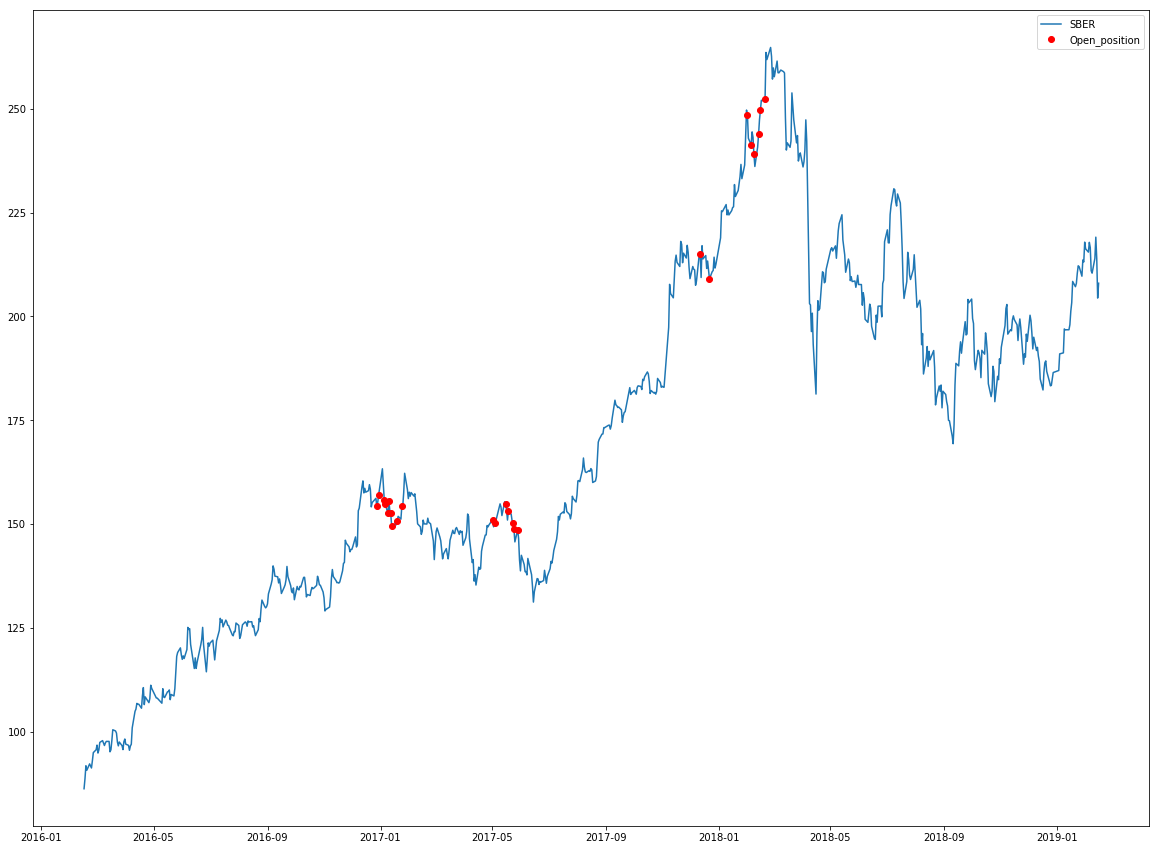

In [49]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='SBER')
#_=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,df.Price_1_init,'bo',color='red',label='Open_position')
__=plt.legend()

## The strategy showed a positive result. However, for the year there were only 3 transactions. Let's try to increase the number of transactions by reducing the window for the calculation of stationarity.

In [50]:
port_reduced=port
n=port_reduced.shape[0]
Instr_1=(np.array((port_reduced.iloc[0:,1]))).reshape(-1,1)
Instr_2=(np.array((port_reduced.iloc[0:,2]))).reshape(-1,1)
Date=list((port_reduced.iloc[0:,0]))
days_stationarity_check_max=20 
days_position_max=3 
window=75 
k=1.5# mu +/- k*sigma
comission=0
stop_profit=0.0001
result=[] 
stationarity_check=False
pos_days=0
i=window
stationatity_check_index=window 

In [51]:
while ((i)<n):
    #print(i)
    if (pos_days==0):
        if (((i-stationatity_check_index)>days_stationarity_check_max)|(i==window)):
            resid,beta=reg_resid_func(Instr_1[(i-window):i],Instr_2[(i-window):i])
            stationarity=stationarity_check_func(resid) 
            if stationarity:
                mean,sigma=param_func(resid)
            stationatity_check_index=i
        if stationarity: 
            price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
            spread=float(np.log(price_1)-np.log(price_2)*beta)
            #print(np.log(price_1),np.log(price_2),spread,mean,sigma,(mean+sigma*k),beta)
            signal=signal_func_open(spread,mean,sigma,k)
            #print(signal)
            if (signal!='No'):  
                pos_direction='Long' if signal=='Buy' else 'Short' 
                pos=Position() 
                pos.initial_position=(Date[i],pos_direction,price_1,price_2,beta,comission)
                pos_days=1
                i+=1
            else: i+=1   
        else: i+=1      
    else:
        price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
        if (pos_days<days_position_max):
            pos.close_position=(Date[i],'Signal',price_1,price_2,comission)
            res=pos.get_result()
            if (res>stop_profit):
                result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
                pos_days=0
            else:
                pos_days+=1
                i+=1
        else:
            pos.close_position=(Date[i],'Time',price_1,price_2,comission)
            result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
            pos_days=0
            #print('Time_close')n=port_reduced.shape[0]


In [52]:
df=pd.DataFrame(result,columns=['Date_open','Direction','Price_1_init','Price_2_init','Beta','Comission_init',\
                        'Date_close','Type','Price_1_close','Price_2_close','Comission_close','Result'])
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2017-01-03,Long,163.327118,121.715103,1.068907,0,2017-01-06,Time,154.776291,118.070526,0,-0.0213
1,2017-01-06,Long,154.776291,118.070526,1.068907,0,2017-01-09,Signal,152.654465,115.842773,0,0.0066
2,2017-01-09,Long,152.654465,115.842773,1.068907,0,2017-01-10,Signal,155.601456,116.368523,0,0.0143
3,2017-01-10,Long,155.601456,116.368523,1.068907,0,2017-01-12,Signal,152.581924,114.167503,0,0.0008
4,2017-01-12,Long,152.581924,114.167503,1.068907,0,2017-01-13,Signal,149.526108,110.727867,0,0.0125
5,2017-01-20,Long,151.874634,112.706108,1.068907,0,2017-01-23,Signal,151.203629,111.191238,0,0.0100
6,2017-04-18,Short,139.098267,101.317871,1.063404,0,2017-04-20,Signal,143.459824,104.614937,0,0.0032
7,2017-05-02,Long,151.103882,114.577415,1.063404,0,2017-05-04,Signal,150.070175,112.902145,0,0.0088
8,2017-05-05,Long,150.342194,114.238792,1.063682,0,2017-05-10,Signal,154.876053,115.842773,0,0.0149
9,2017-05-16,Long,154.749100,117.027939,1.063682,0,2017-05-19,Time,153.125977,116.822990,0,-0.0087


In [53]:
sum(df.Result*1000000)

52200.0

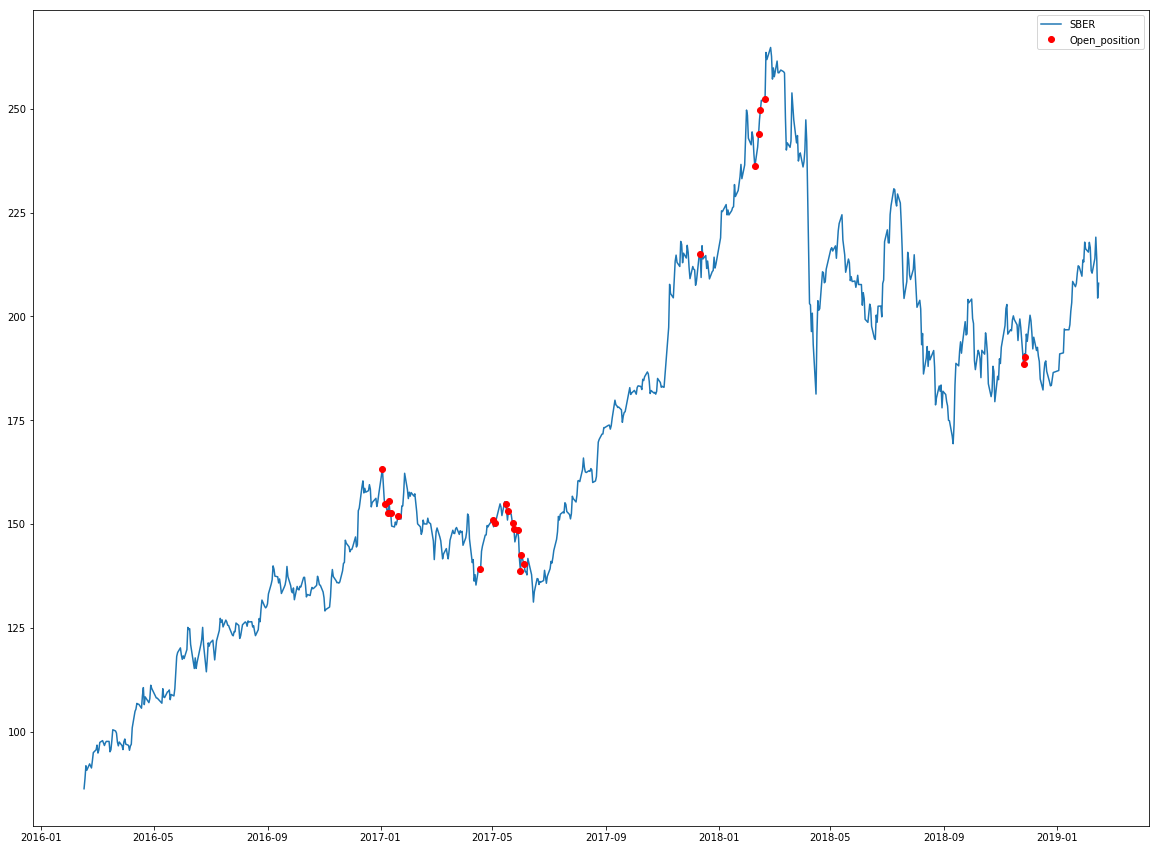

In [54]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='SBER')
#_=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,df.Price_1_init,'bo',color='red',label='Open_position')
__=plt.legend()

## The result of the strategy has deteriorated. And the number of operations decreased. Let's try to reduce the calculation window

In [55]:
port_reduced=port
n=port_reduced.shape[0]
Instr_1=(np.array((port_reduced.iloc[0:,1]))).reshape(-1,1)
Instr_2=(np.array((port_reduced.iloc[0:,2]))).reshape(-1,1)
Date=list((port_reduced.iloc[0:,0]))
days_stationarity_check_max=20 
days_position_max=3 
window=25 
k=1.5# mu +/- k*sigma
comission=0
stop_profit=0.0001
result=[] 
stationarity_check=False
pos_days=0
i=window
stationatity_check_index=window 

In [56]:
while ((i)<n):
    #print(i)
    if (pos_days==0):
        if (((i-stationatity_check_index)>days_stationarity_check_max)|(i==window)):
            resid,beta=reg_resid_func(Instr_1[(i-window):i],Instr_2[(i-window):i])
            stationarity=stationarity_check_func(resid)
            if stationarity:
                mean,sigma=param_func(resid)
            stationatity_check_index=i
        if stationarity: 
            price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
            spread=float(np.log(price_1)-np.log(price_2)*beta)
            #print(np.log(price_1),np.log(price_2),spread,mean,sigma,(mean+sigma*k),beta)
            signal=signal_func_open(spread,mean,sigma,k)
            #print(signal)
            if (signal!='No'):
                pos_direction='Long' if signal=='Buy' else 'Short' 
                pos=Position() 
                pos.initial_position=(Date[i],pos_direction,price_1,price_2,beta,comission)
                pos_days=1
                i+=1
            else: i+=1   
        else: i+=1      
    else:
        price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
        if (pos_days<days_position_max):
            pos.close_position=(Date[i],'Signal',price_1,price_2,comission)
            res=pos.get_result()
            if (res>stop_profit):
                result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
                pos_days=0
            else:
                pos_days+=1
                i+=1
        else:
            pos.close_position=(Date[i],'Time',price_1,price_2,comission)
            result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
            pos_days=0
            #print('Time_close')n=port_reduced.shape[0]


In [57]:
df=pd.DataFrame(result,columns=['Date_open','Direction','Price_1_init','Price_2_init','Beta','Comission_init',\
                        'Date_close','Type','Price_1_close','Price_2_close','Comission_close','Result'])
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2016-09-22,Long,139.805542,99.330727,1.077357,0,2016-09-23,Signal,137.375412,97.468323,0,0.0029
1,2016-09-23,Long,137.375412,97.468323,1.077357,0,2016-09-28,Time,133.458160,97.307930,0,-0.0272
2,2016-09-28,Long,133.458160,97.307930,1.077357,0,2016-09-29,Signal,134.627899,97.129715,0,0.0107
3,2016-09-29,Long,134.627899,97.129715,1.077357,0,2016-09-30,Signal,131.789719,94.296021,0,0.0106
4,2016-09-30,Long,131.789719,94.296021,1.077357,0,2016-10-05,Time,134.156387,96.844559,0,-0.0109
5,2016-10-05,Long,134.156387,96.844559,1.077357,0,2016-10-10,Time,137.166855,101.050545,0,-0.0236
6,2016-10-10,Long,137.166855,101.050545,1.077357,0,2016-10-13,Time,132.469803,98.600021,0,-0.0084
7,2016-10-13,Long,132.469803,98.600021,1.077357,0,2016-10-14,Signal,133.050125,98.555466,0,0.0049
8,2016-10-14,Long,133.050125,98.555466,1.077357,0,2016-10-17,Signal,132.805298,98.190117,0,0.0022
9,2016-10-17,Long,132.805298,98.190117,1.077357,0,2016-10-18,Signal,133.965958,98.840614,0,0.0016


In [58]:
sum(df.Result*1000000)

6800.000000000002

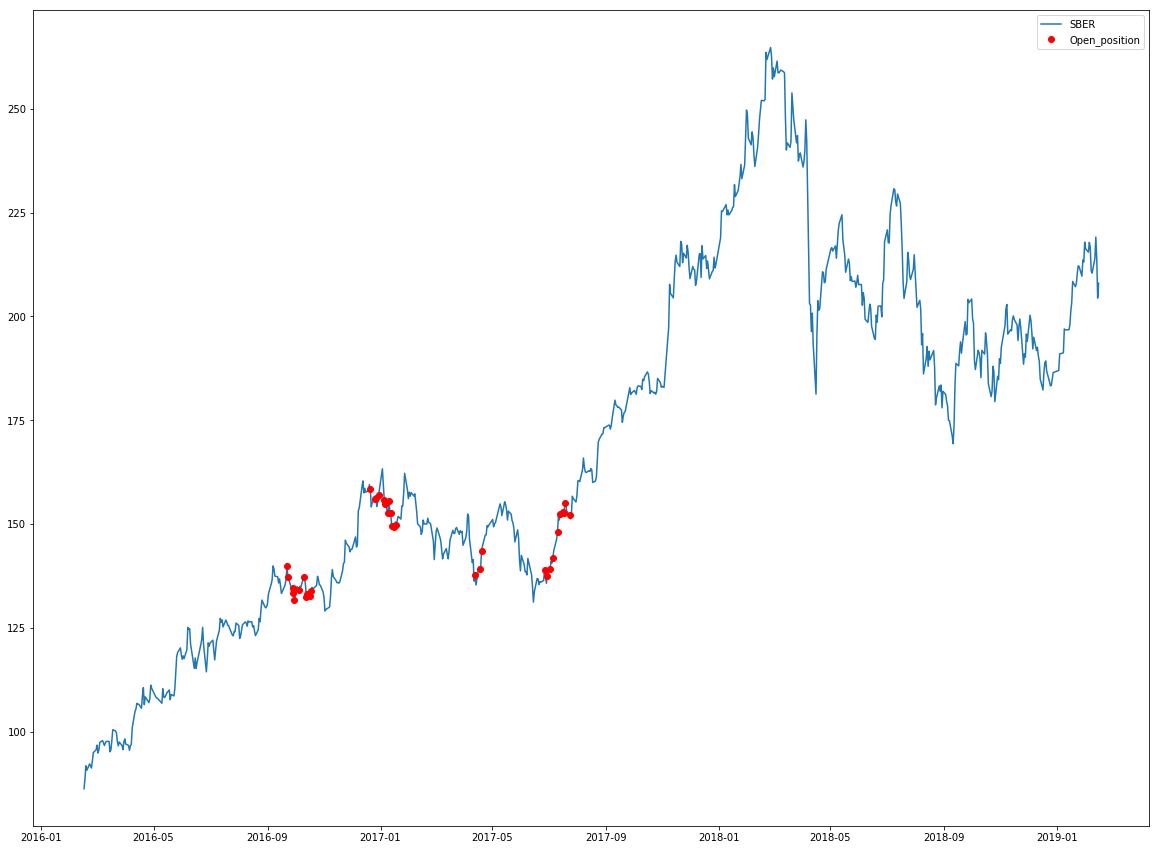

In [59]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='SBER')
#_=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,df.Price_1_init,'bo',color='red',label='Open_position')
__=plt.legend()

## Summary:
#### 1. The strategy is very sensitive to the length of the calculation window. Accordingly, it is necessary to constantly monitor the effectiveness of the strategy in order to avoid losses due to changes in the effective window.
#### 2. Income from each transaction is less than a percent. therefore, if the total Bid/Ask for both securities exceeds the yield, the result of the strategy will be unprofitable.
#### 3. It is also necessary to take into account the possible change in commissions, which can also greatly worsen the result of the strategy.